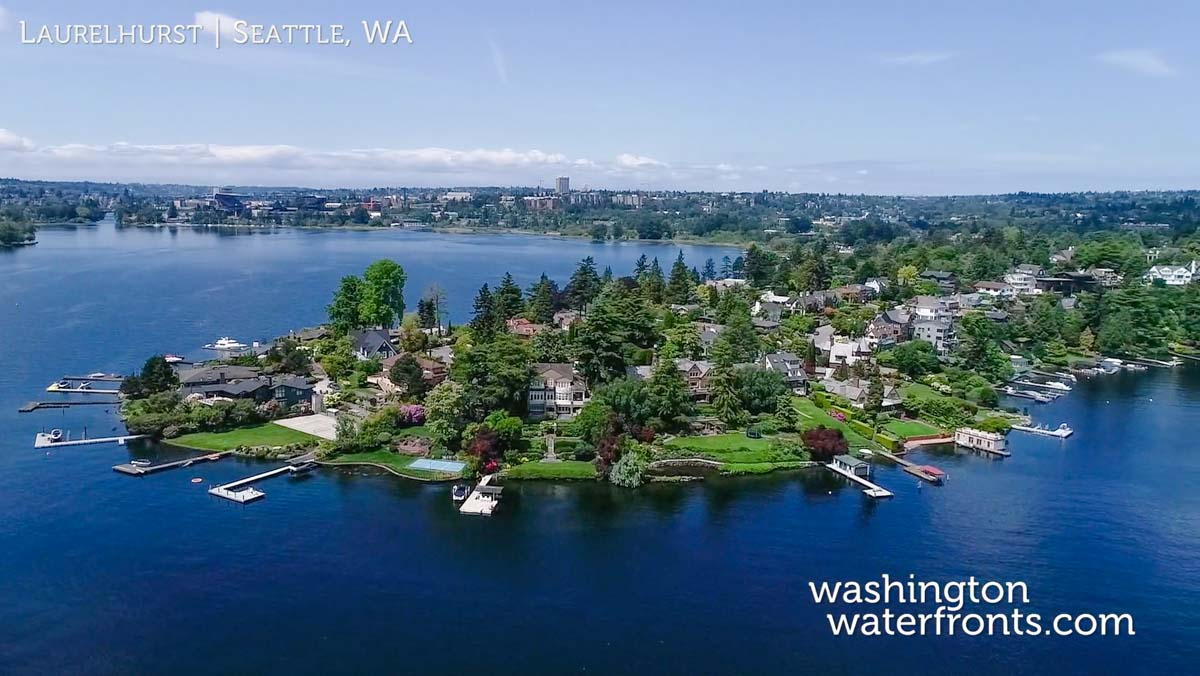

In [1]:
from IPython.core.display import Image, display
display(Image('https://assets.site-static.com/userFiles/628/image/Seattle-laurelhurst-waterfront-real-estate.jpg', width=1900))

# EDA "A waterfront house in King County" - Presentation edition

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
import statsmodels.api as sms
import statsmodels.formula.api as smf
import warnings
from bokeh.plotting import figure, output_file, output_notebook, show  
from bokeh.tile_providers import OSM, get_provider

%matplotlib inline

In [3]:
kingcnt = pd.read_csv("data/King_County_House_prices_dataset.csv")

In [4]:
df_kingcnt = DataFrame(kingcnt,columns=['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']) 

## Understand

### Stakeholder briefing

Question from stakeholder:
What compromises do I need to make if I want to buy a house with mid to mid-high price?

Potential compromises defined by the stakeholder are:
* waterfront
* neighbourhood
* renovation
* condition

What impact do these compromises have on the price?

Other wishes of the stakeholder are:
* 2 bedrooms (one child)
* 2 bathrooms (own bathroom, because afraid of germs)
* no outskirts
* no crowded neighbourhood

## Assume

More expensive houses:
1. have a waterfront view
2. are in a good neighbourhood, meaning that:

     a. the 15 nearest houses are large
     
     b. the 15 nearest houses have large plots
     
3. have been renovated
4. are in a good condition

## Explore

The column name and description of the variables included in the EDA are reported the table below.

column name | description
------------|-------------
price | price of the house
waterfront | house has a view to the waterfront
sqft_living15 | space of the 15 closest neighboring houses in square feet
sqft_lot15 | space of the 15 closest neighboring plots in square feet
yr_renovated | most recent year in which the house was renovated
condition | overall condition of the house

### Numerical data

Transform the data to improve visualization.

In [5]:
df_kingcnt['price_log'] = np.log(df_kingcnt['price'])

In [6]:
df_kingcnt['lot15_log'] = np.log(df_kingcnt['sqft_lot15'])

Check the numerical data for outliers.

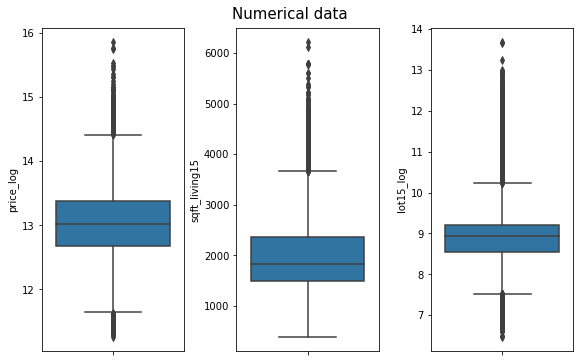

In [7]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(8, 5))
index = 0
axs = axs.flatten()
df_numerical = df_kingcnt[['price_log', 'sqft_living15','lot15_log']]

for c,v in df_numerical.items():
    sns.boxplot(y=c, data=df_numerical, ax=axs[index])
    index += 1

plt.suptitle("Numerical data", fontsize=15)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

### House prices

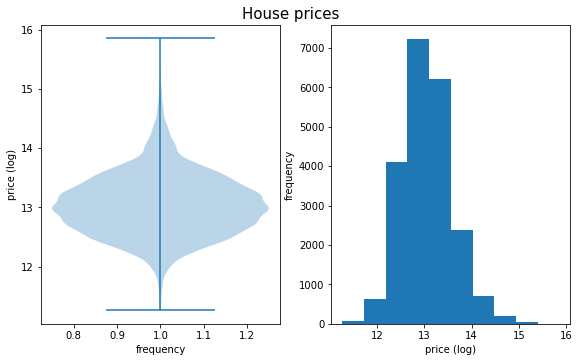

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
plt.suptitle("House prices", fontsize=15)

ax[0].violinplot(df_kingcnt.price_log);
ax[0].set(xlabel="frequency")
ax[0].set(ylabel="price (log)")

ax[1].hist(df_kingcnt.price_log);
ax[1].set(xlabel="price (log)")
ax[1].set(ylabel="frequency")

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

### Neighborhood

#### Size of neighboring houses

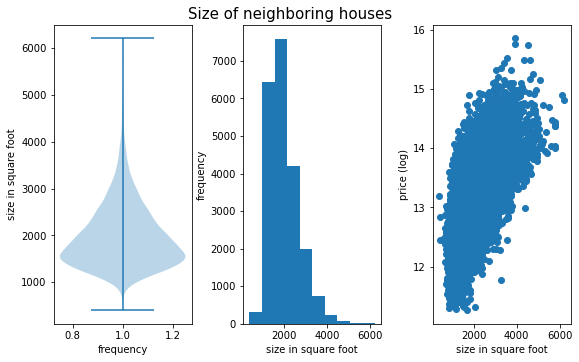

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(8, 5))
plt.suptitle("Size of neighboring houses", fontsize=15)

ax[0].violinplot(df_kingcnt.sqft_living15);
ax[0].set(xlabel="frequency")
ax[0].set(ylabel="size in square foot")

ax[1].hist(df_kingcnt.sqft_living15);
ax[1].set(xlabel="size in square foot")
ax[1].set(ylabel="frequency")

ax[2].scatter(x = df_kingcnt.sqft_living15, y = df_kingcnt.price_log);
ax[2].set(xlabel="size in square foot")
ax[2].set(ylabel="price (log)")
          
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

Houses with larger houses in the neighborhood seem more expensive.

#### Land plot of neighboring houses

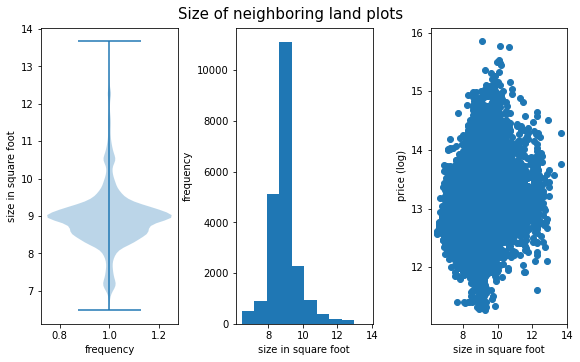

In [10]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(8, 5))
plt.suptitle("Size of neighboring land plots", fontsize=15)

ax[0].violinplot(df_kingcnt.lot15_log);
ax[0].set(xlabel="frequency")
ax[0].set(ylabel="size in square foot")

ax[1].hist(df_kingcnt.lot15_log);
ax[1].set(xlabel="size in square foot")
ax[1].set(ylabel="frequency")

ax[2].scatter(x = df_kingcnt.lot15_log, y = df_kingcnt.price_log);
ax[2].set(xlabel="size in square foot")
ax[2].set(ylabel="price (log)")
          
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

Based on the scatter plot, there does not seem to be a relationship between the size of the neighboring plots and the price.

## Categorical data

### Waterfront view

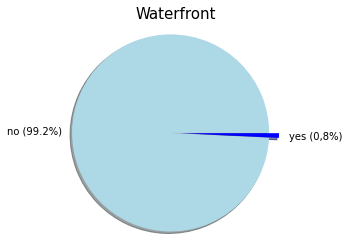

In [11]:
labels = 'no (99.2%)', 'yes (0,8%)'
colors = ['lightblue', 'blue']
explode = (0.1, 0)  # explode 1st slice

plt.pie(df_kingcnt.waterfront.value_counts(), explode=explode, labels=labels, colors=colors, 
        shadow=True, startangle=0)

plt.title("Waterfront", fontsize = 15)
plt.axis('equal')
plt.show()

There are very few waterfront houses. Are waterfront houses more expensive?

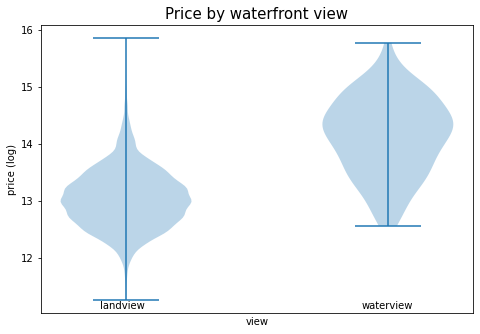

In [12]:
landview = df_kingcnt.query('waterfront == 0')['price_log']
waterview = df_kingcnt.query('waterfront == 1')['price_log']

waterfront_price = [landview, waterview]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

bp = ax.violinplot(waterfront_price)
bp = ax.set_title("Price by waterfront view", fontsize=15)
bp = ax.set_xlabel("view")
bp = ax.set_ylabel("price (log)")
bp = ax.text(0.9,11.1, 'landview')
bp = ax.text(1.9,11.1, 'waterview')

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.show()

Waterfront houses seem to be more expensive.

### Renovated: recoded renovation year.

In [13]:
df_kingcnt['renovated'] = df_kingcnt['yr_renovated'] > 0

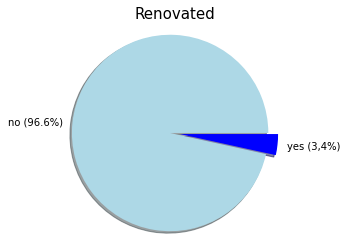

In [14]:
labels = 'no (96.6%)', 'yes (3,4%)'
colors = ['lightblue', 'blue']
explode = (0.1, 0)  # explode 1st slice

plt.pie(df_kingcnt.renovated.value_counts(), explode=explode, labels=labels, colors=colors, 
        shadow=True, startangle=0)

plt.title("Renovated", fontsize = 15)
plt.axis('equal')
plt.show()

There are very few renovated houses. Are renovated houses more expensive?

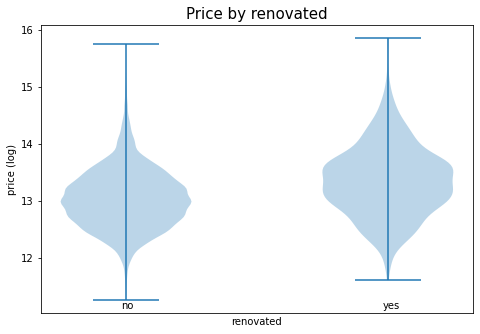

In [15]:
renovated_no = df_kingcnt.query('renovated == False')['price_log']
renovated_yes = df_kingcnt.query('renovated == True')['price_log']

renovated_price = [renovated_no, renovated_yes]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

bp = ax.violinplot(renovated_price)
bp = ax.text(0.98,11.1, 'no')
bp = ax.text(1.98,11.1, 'yes')
bp = ax.set_title("Price by renovated", fontsize=15)
bp = ax.set_xlabel("renovated")
bp = ax.set_ylabel("price (log)")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.show()

Renovated houses seem more expensive than not renovated houses.

### Condition

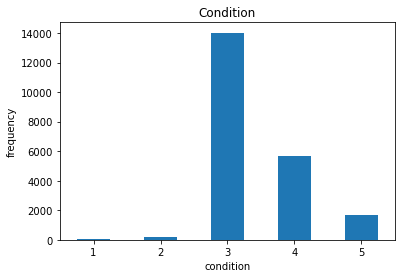

In [16]:
df_kingcnt.condition.value_counts().sort_index().plot(kind = "bar", title="Condition", xlabel="condition", ylabel="frequency", rot=0);

Most houses have condition 3. Are houses in conditions 4 and 5 more expensive than those in condition 3?

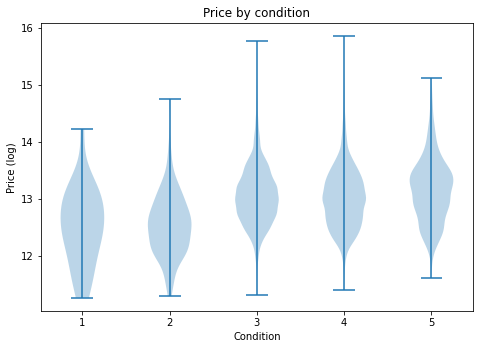

In [17]:
condition_1 = df_kingcnt.query('condition == 1')['price_log']
condition_2 = df_kingcnt.query('condition == 2')['price_log']
condition_3 = df_kingcnt.query('condition == 3')['price_log']
condition_4 = df_kingcnt.query('condition == 4')['price_log']
condition_5 = df_kingcnt.query('condition == 5')['price_log']

condition_price = [condition_1, condition_2, condition_3, condition_4, condition_5]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
bp = ax.set_title("Price by condition")
bp = ax.set_xlabel("Condition")
bp = ax.set_ylabel("Price (log)")
bp = ax.violinplot(condition_price)

plt.show()

There only seems to be difference in price between the first two conditions, in which there is hardly any data, and the rest.

## Clean: replace missing values.

In [18]:
df_kingcnt.fillna({'waterfront':0}, inplace=True)

## Relate

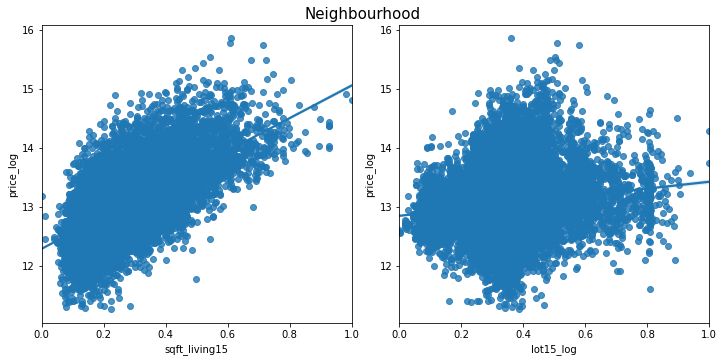

In [19]:
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['sqft_living15', 'lot15_log']
x = df_kingcnt.loc[:,column_sels]
y = df_kingcnt['price_log']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
    
plt.suptitle("Neighbourhood", fontsize=15)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)
warnings.filterwarnings('ignore')

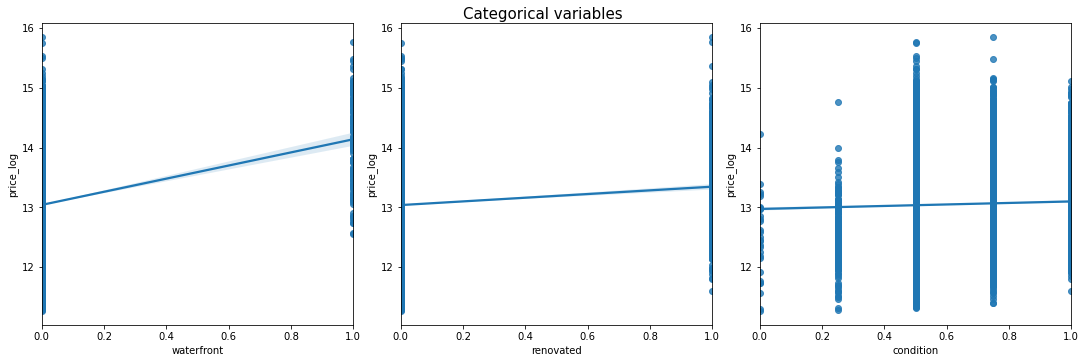

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['waterfront', 'renovated', 'condition']
x = df_kingcnt.loc[:,column_sels]
y = df_kingcnt['price_log']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
    
plt.suptitle("Categorical variables", fontsize = 15)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
warnings.filterwarnings('ignore')

### Neighbourhood

#### Size of surrounding houses
* The impact of the size of the surrounding houses is .384.

In [21]:
#R-squared
rs = smf.ols(formula='price_log~sqft_living15', data=df_kingcnt).fit().rsquared
f'{rs:.3}'

'0.384'

#### Size of the surrounding plots
* The impact of the size of the surrounding plots is .0153.

In [22]:
#R-squared
rs = smf.ols(formula='price_log~lot15_log', data=df_kingcnt).fit().rsquared
f'{rs:.3}'

'0.0153'

### Waterfront
* The standard deviations of the log transformed prices of the houses with and without waterfront are comparable.
* Houses with waterfront are significantly more expensive than houses without waterfront.
* The impact of waterfront on the price is .0291.

In [23]:
#standard deviations
df_kingcnt.groupby('waterfront')['price_log'].std()

waterfront
0.0    0.517519
1.0    0.686429
Name: price_log, dtype: float64

In [24]:
#anova
model_water = smf.ols('price_log~waterfront', data=df_kingcnt).fit()
print(sms.stats.anova_lm(model_water, typ=2))

                 sum_sq       df           F         PR(>F)
waterfront   174.513643      1.0  648.287799  6.303414e-141
Residual    5813.193039  21595.0         NaN            NaN


In [25]:
#R-squared
rs = smf.ols(formula='price_log~waterfront', data=df_kingcnt).fit().rsquared
f'{rs:.3}'

'0.0291'

### Renovation
* The standard deviations of the log transformed prices of the renovated houses are comparable to those that were not renovated.
* Renovated houses are significantly more expensive than not renovated ones.
* The impact of renovation on the price is .0103.

In [26]:
#standard deviations
df_kingcnt.groupby('renovated')['price_log'].std()

renovated
False    0.519781
True     0.620570
Name: price_log, dtype: float64

In [27]:
#anova
model_renovated = smf.ols('price_log~renovated', data=df_kingcnt).fit()
print(sms.stats.anova_lm(model_renovated, typ=2))

                sum_sq       df           F        PR(>F)
renovated    67.949685      1.0  247.877312  1.535541e-55
Residual   5919.756997  21595.0         NaN           NaN


In [28]:
#R-squared
rs = smf.ols(formula='price_log~renovated', data=df_kingcnt).fit().rsquared
f'{rs:.3}'

'0.0113'

### Condition
* The standard deviations of the log transformed prices of houses in each condition are comparable.
* Houses with better conditions are significantly more expensive than those in worse conditions.
* The impact of condition on the price is .00151.

In [29]:
#standard deviation
df_kingcnt.groupby('condition')['price_log'].std()

condition
1    0.675849
2    0.540546
3    0.516417
4    0.526025
5    0.560970
Name: price_log, dtype: float64

In [30]:
#anova
model_condition = smf.ols('price_log~condition', data=df_kingcnt).fit()
print(sms.stats.anova_lm(model_condition, typ=2))

                sum_sq       df          F        PR(>F)
condition     9.069161      1.0  32.758053  1.057555e-08
Residual   5978.637522  21595.0        NaN           NaN


In [31]:
#R-squared
rs = smf.ols(formula='price_log~condition', data=df_kingcnt).fit().rsquared
f'{rs:.3}'

'0.00151'

### Multiple linear regression
R-squared and adjusted R-squared for the full model are .437, so all variables together do not have a large impact on the price.

In [32]:
smf.ols(formula='price_log~waterfront+sqft_living15+lot15_log+renovated+condition', data=df_kingcnt).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     3348.
Date:                Sat, 17 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:38:40   Log-Likelihood:                -10594.
No. Observations:               21597   AIC:                         2.120e+04
Df Residuals:                   21591   BIC:                         2.125e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.5540      0.032    390.213      0.000      12.491      12.617
renovated[T.True]     0.3080      0.015     20.788      0.000       0.279       0.337
waterfront            0.7481      0.033     22.612      0.000       0.683       0.813
sqft_living15         0.0005   4.28e-06    121.590      0.000       0.001       0.001
lot15_log            -0.0984      0.004    -27.291      0.000      -0.105      -0.091
condition             0.0956      0.004     22.793      0.000       0.087       0.104
==============================================================================
Omnibus:                      411.858   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              551.274
Skew:                           0.245   Prob(JB):                    1.96e-120
Kurtosis:                       3.610   Cond. No.                     2.65e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assume

It was assumed that more expensive houses:
1. have a waterfront view - CORRECT
2. are in a good neighbourhood, meaning that:

     a. the 15 nearest houses are large - CORRECT
     
     b. the 15 nearest houses have large plots - INCORRECT
     
3. have been renovated - CORRECT
4. are in a good condition - CORRECT

However, all these factors individually and in combination do not have a large impact on the price of the house. Does this mean you do not have to compromise?

## Fine tune

Wishes of the stakeholder were:
* 2 bedrooms
* 2 bathrooms
* mid to mid high price
* waterfront if possible

The locations of the houses meeting these requirements are shown on the map below.

In [33]:
selection = df_kingcnt.query('bedrooms == 2 and bathrooms == 2 and sqft_living15 >= 1840 and price_log > 13.017003 and price_log < 13.377006 and condition > 2')

In [34]:
# file to save the model  
output_file("kcmap.html")  
output_notebook()

# instantiating the figure object  
graph = figure(title = "Map of House Sales in King County", x_axis_type="mercator", y_axis_type="mercator")

#tile provider
tile_provider = get_provider(OSM)
graph.add_tile(tile_provider)

# name of the x-axis  
graph.xaxis.axis_label = "Long"

# name of the y-axis  
graph.yaxis.axis_label = "Lat"

# points to be plotted converted to mercator
k = 6378137
x = selection.long.apply(lambda x: x * (k * np.pi/180.0))
y = selection.lat.apply(lambda x: np.log(np.tan((90 + x) * np.pi/360.0)) * k)
size = 8

# plotting the graph  
graph.scatter(x, y, 
              fill_alpha=0.1,
              size = size)  

# displaying the model  
show(graph)

Loading BokehJS ...

## Explain

* Characteristics:
 * waterfront view
 * good neighborhood with larger houses
 * renovated houses
* Generally more expensive.
* No large impact on price.

* Availability renovated and waterfront is sparse.
* 21 houses (0.09% of all houses sold between May 2014 and May 2015):
 * 2 bedrooms
 * 2 bathrooms
 * good neighborhood
 * that have a mid to mid-high price
* But:
 * 10 less crowded neighborhoods,
 * 11 in outskirts, 1 waterfront house.

Stakeholder may have to wait long until she finds a house that fulfills all her wishes, or she would need to compromise.